# Multi-Output Regression

We are building a model with which to forecast future periods based on prior data.
We use CS_Index as our dependent variable, and predict its value.

1. Read the data set.
2. Create predictor columns:
   - Since we have historical time series set, we use the data in the next period 
       for the "future" data in the current period  
       - 1 month in future, based on the next CS_Index period value 
       - 4 months in the future, similar to above
       - Same for 7 months and 13 months
   - This gives us next month, next quarter, next half, and next year values.
3. Split data into training and testing data.
4. Scale the data. Our values have a wide range.
5. Use multioutput regresion with elasticnet as estimator
6. Fit the data to the model
7. Print RMSE values
8. Plot Residuals for 1 month, 4 month, 7 month, and 13 month (optional, for our edification)
9. Save the model. 
10. We can use model.predict to get forecasted values. A visualization might include plot of historical data, along with predicted values n periods into the future.
11. Fancy: use box plot to show margin of error



In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [3]:
# Read the data set.
df = pd.read_csv("../Data/dataset.csv")
df.tail()

,period,CS_Index,West North Central,New England,East North Central,Middle Atlantic,Mountain,Pacific,South Atlantic,West South Central,USA,Housing Affordability Index,Market Absorption Rate (%),Unemployment Rate,Financial obligations ratio,Consumer debt service ratio,Debt service ratio,Mortgage debt service ratio
221,2018-June,211.324397,262.34,249.15,218.29,236.38,355.85,307.12,266.19,277.34,263.68,137.7,56.0,4.0,15.328434,5.610062,9.855333,4.245272
222,2018-July,211.607529,263.45,249.07,219.36,237.51,355.49,308.82,269.05,277.73,264.87,140.3,52.0,3.9,15.328742,5.618410,9.857297,4.238888
223,2018-August,211.112328,264.27,250.86,220.21,236.87,358.27,310.76,270.93,279.34,266.18,142.3,47.0,3.8,15.327507,5.623304,9.865548,4.242244
224,2018-September,212.681557,264.03,251.75,221.81,237.78,362.62,308.92,271.75,280.25,266.95,147.5,46.0,3.7,15.326273,5.628199,9.873798,4.245599
225,2018-October,213.479024,267.45,253.53,223.02,237.72,363.93,313.20,271.07,280.90,268.27,147.1,43.0,3.8,15.325038,5.633093,9.882049,4.248955


In [4]:
# Let's ignore the regional data
df = df.drop(columns = ['West North Central','New England','East North Central','Middle Atlantic','Mountain','Pacific','South Atlantic','West South Central'])
df.head()

,period,CS_Index,USA,Housing Affordability Index,Market Absorption Rate (%),Unemployment Rate,Financial obligations ratio,Consumer debt service ratio,Debt service ratio,Mortgage debt service ratio
0,2000-January,100.589697,137.42,126.0,67.0,4.0,16.532775,5.937883,11.503203,5.565320
1,2000-February,101.692479,137.26,126.6,78.0,4.1,16.574865,5.973133,11.555449,5.582317
2,2000-March,102.783829,138.32,125.1,88.0,4.0,16.616956,6.008382,11.607695,5.599313
3,2000-April,103.996444,139.26,124.1,78.0,3.8,16.659046,6.043632,11.659941,5.616310
4,2000-May,105.252818,139.89,121.0,77.0,4.0,16.708283,6.088313,11.718836,5.630523


Create predictor columns

In [5]:
# Next month column, create current value based on CS_index next value (current "next month prediction" based on actual next month value)
next_month = df['CS_Index'].shift(-1, axis=0)
df['CS_1_month'] = next_month
df.head()

,period,CS_Index,USA,Housing Affordability Index,Market Absorption Rate (%),Unemployment Rate,Financial obligations ratio,Consumer debt service ratio,Debt service ratio,Mortgage debt service ratio,CS_1_month
0,2000-January,100.589697,137.42,126.0,67.0,4.0,16.532775,5.937883,11.503203,5.565320,101.692479
1,2000-February,101.692479,137.26,126.6,78.0,4.1,16.574865,5.973133,11.555449,5.582317,102.783829
2,2000-March,102.783829,138.32,125.1,88.0,4.0,16.616956,6.008382,11.607695,5.599313,103.996444
3,2000-April,103.996444,139.26,124.1,78.0,3.8,16.659046,6.043632,11.659941,5.616310,105.252818
4,2000-May,105.252818,139.89,121.0,77.0,4.0,16.708283,6.088313,11.718836,5.630523,106.402524


In [6]:
# Next quarter, or four months
next_quarter = df['CS_Index'].shift(-3, axis=0)
df['CS_3_month'] = next_quarter
df.head()

,period,CS_Index,USA,Housing Affordability Index,Market Absorption Rate (%),Unemployment Rate,Financial obligations ratio,Consumer debt service ratio,Debt service ratio,Mortgage debt service ratio,CS_1_month,CS_3_month
0,2000-January,100.589697,137.42,126.0,67.0,4.0,16.532775,5.937883,11.503203,5.565320,101.692479,103.996444
1,2000-February,101.692479,137.26,126.6,78.0,4.1,16.574865,5.973133,11.555449,5.582317,102.783829,105.252818
2,2000-March,102.783829,138.32,125.1,88.0,4.0,16.616956,6.008382,11.607695,5.599313,103.996444,106.402524
3,2000-April,103.996444,139.26,124.1,78.0,3.8,16.659046,6.043632,11.659941,5.616310,105.252818,107.134019
4,2000-May,105.252818,139.89,121.0,77.0,4.0,16.708283,6.088313,11.718836,5.630523,106.402524,107.861438


In [7]:
# Next half, or 6 months
next_half = df['CS_Index'].shift(-6, axis=0)
df['CS_6_month'] = next_half 
df.head()


,period,CS_Index,USA,Housing Affordability Index,Market Absorption Rate (%),Unemployment Rate,Financial obligations ratio,Consumer debt service ratio,Debt service ratio,Mortgage debt service ratio,CS_1_month,CS_3_month,CS_6_month
0,2000-January,100.589697,137.42,126.0,67.0,4.0,16.532775,5.937883,11.503203,5.565320,101.692479,103.996444,107.134019
1,2000-February,101.692479,137.26,126.6,78.0,4.1,16.574865,5.973133,11.555449,5.582317,102.783829,105.252818,107.861438
2,2000-March,102.783829,138.32,125.1,88.0,4.0,16.616956,6.008382,11.607695,5.599313,103.996444,106.402524,108.610140
3,2000-April,103.996444,139.26,124.1,78.0,3.8,16.659046,6.043632,11.659941,5.616310,105.252818,107.134019,109.486859
4,2000-May,105.252818,139.89,121.0,77.0,4.0,16.708283,6.088313,11.718836,5.630523,106.402524,107.861438,110.571707


In [8]:
# 13 months, for one year from now
next_year = df['CS_Index'].shift(-12, axis=0)
df['CS_12_month'] = next_year
df.head(14)

,period,CS_Index,USA,Housing Affordability Index,Market Absorption Rate (%),Unemployment Rate,Financial obligations ratio,Consumer debt service ratio,Debt service ratio,Mortgage debt service ratio,CS_1_month,CS_3_month,CS_6_month,CS_12_month
0,2000-January,100.589697,137.42,126.0,67.0,4.0,16.532775,5.937883,11.503203,5.565320,101.692479,103.996444,107.134019,113.053498
1,2000-February,101.692479,137.26,126.6,78.0,4.1,16.574865,5.973133,11.555449,5.582317,102.783829,105.252818,107.861438,114.126858
2,2000-March,102.783829,138.32,125.1,88.0,4.0,16.616956,6.008382,11.607695,5.599313,103.996444,106.402524,108.610140,115.085196
3,2000-April,103.996444,139.26,124.1,78.0,3.8,16.659046,6.043632,11.659941,5.616310,105.252818,107.134019,109.486859,115.840551
4,2000-May,105.252818,139.89,121.0,77.0,4.0,16.708283,6.088313,11.718836,5.630523,106.402524,107.861438,110.571707,116.300743
5,2000-June,106.402524,140.82,118.4,71.0,4.0,16.757520,6.132995,11.777730,5.644737,107.134019,108.610140,111.800872,116.899750
6,2000-July,107.134019,141.58,117.0,76.0,4.0,16.806757,6.177676,11.836625,5.658950,107.861438,109.486859,113.053498,117.496601
7,2000-August,107.861438,142.12,119.3,73.0,4.1,16.890217,6.232203,11.912198,5.679996,108.610140,110.571707,114.126858,118.245229
8,2000-September,108.610140,143.03,120.3,70.0,3.9,16.973676,6.286730,11.987772,5.701042,109.486859,111.800872,115.085196,119.027953
9,2000-October,109.486859,143.81,124.6,71.0,3.9,17.057136,6.341257,12.063345,5.722088,110.571707,113.053498,115.840551,119.694049


In [9]:
df.tail()

,period,CS_Index,USA,Housing Affordability Index,Market Absorption Rate (%),Unemployment Rate,Financial obligations ratio,Consumer debt service ratio,Debt service ratio,Mortgage debt service ratio,CS_1_month,CS_3_month,CS_6_month,CS_12_month
221,2018-June,211.324397,263.68,137.7,56.0,4.0,15.328434,5.610062,9.855333,4.245272,211.607529,212.681557,NaN,NaN
222,2018-July,211.607529,264.87,140.3,52.0,3.9,15.328742,5.618410,9.857297,4.238888,211.112328,213.479024,NaN,NaN
223,2018-August,211.112328,266.18,142.3,47.0,3.8,15.327507,5.623304,9.865548,4.242244,212.681557,NaN,NaN,NaN
224,2018-September,212.681557,266.95,147.5,46.0,3.7,15.326273,5.628199,9.873798,4.245599,213.479024,NaN,NaN,NaN
225,2018-October,213.479024,268.27,147.1,43.0,3.8,15.325038,5.633093,9.882049,4.248955,NaN,NaN,NaN,NaN


In [10]:
# We should save those non-NaN values before we drop them. They'll come in handy later.
# Use .copy(), else the dropna below will operatate on original, too.
df_oct2018 = df.copy()
# Drop the NaNs


In [11]:
df_oct2018.tail()

,period,CS_Index,USA,Housing Affordability Index,Market Absorption Rate (%),Unemployment Rate,Financial obligations ratio,Consumer debt service ratio,Debt service ratio,Mortgage debt service ratio,CS_1_month,CS_3_month,CS_6_month,CS_12_month
221,2018-June,211.324397,263.68,137.7,56.0,4.0,15.328434,5.610062,9.855333,4.245272,211.607529,212.681557,NaN,NaN
222,2018-July,211.607529,264.87,140.3,52.0,3.9,15.328742,5.618410,9.857297,4.238888,211.112328,213.479024,NaN,NaN
223,2018-August,211.112328,266.18,142.3,47.0,3.8,15.327507,5.623304,9.865548,4.242244,212.681557,NaN,NaN,NaN
224,2018-September,212.681557,266.95,147.5,46.0,3.7,15.326273,5.628199,9.873798,4.245599,213.479024,NaN,NaN,NaN
225,2018-October,213.479024,268.27,147.1,43.0,3.8,15.325038,5.633093,9.882049,4.248955,NaN,NaN,NaN,NaN


In [12]:

df.dropna(axis=0,inplace=True)
df.tail()


,period,CS_Index,USA,Housing Affordability Index,Market Absorption Rate (%),Unemployment Rate,Financial obligations ratio,Consumer debt service ratio,Debt service ratio,Mortgage debt service ratio,CS_1_month,CS_3_month,CS_6_month,CS_12_month
209,2017-June,198.725571,246.48,147.8,56.0,4.3,15.517216,5.656457,9.979874,4.323418,199.760367,202.133162,205.896187,211.324397
210,2017-July,199.760367,248.00,151.2,48.0,4.3,15.509082,5.656659,9.975555,4.318896,199.984586,203.357326,207.317264,211.607529
211,2017-August,199.984586,249.88,153.9,45.0,4.4,15.495432,5.659247,9.967493,4.308246,202.133162,204.695198,208.785257,211.112328
212,2017-September,202.133162,251.02,160.1,50.0,4.2,15.481781,5.661836,9.959432,4.297596,203.357326,205.896187,210.857946,212.681557
213,2017-October,203.357326,253.04,162.7,49.0,4.1,15.468131,5.664424,9.951370,4.286946,204.695198,207.317264,210.394373,213.479024


In [13]:
df_oct2018.tail()

,period,CS_Index,USA,Housing Affordability Index,Market Absorption Rate (%),Unemployment Rate,Financial obligations ratio,Consumer debt service ratio,Debt service ratio,Mortgage debt service ratio,CS_1_month,CS_3_month,CS_6_month,CS_12_month
221,2018-June,211.324397,263.68,137.7,56.0,4.0,15.328434,5.610062,9.855333,4.245272,211.607529,212.681557,NaN,NaN
222,2018-July,211.607529,264.87,140.3,52.0,3.9,15.328742,5.618410,9.857297,4.238888,211.112328,213.479024,NaN,NaN
223,2018-August,211.112328,266.18,142.3,47.0,3.8,15.327507,5.623304,9.865548,4.242244,212.681557,NaN,NaN,NaN
224,2018-September,212.681557,266.95,147.5,46.0,3.7,15.326273,5.628199,9.873798,4.245599,213.479024,NaN,NaN,NaN
225,2018-October,213.479024,268.27,147.1,43.0,3.8,15.325038,5.633093,9.882049,4.248955,NaN,NaN,NaN,NaN


Data Preprocessing

In [14]:
# Set up our variables. 
# Y axis is our predictions
# 
Y = df[['CS_1_month','CS_3_month','CS_6_month','CS_12_month']]
X = df.drop(columns= ['period','CS_1_month','CS_3_month','CS_6_month','CS_12_month'])

In [15]:
print("Shape: ", X.shape, Y.shape)

Shape:  (214, 9) (214, 4)


In [16]:
# Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42)

In [17]:
# Do some scaling to normalize the data
from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler().fit(X_train)
Y_scaler = StandardScaler().fit(Y_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
Y_train_scaled = Y_scaler.transform(Y_train)
Y_test_scaled = Y_scaler.transform(Y_test)

In [18]:
# We're using ElasticNet to create an estimator to use within MultiOutputRegressor 
# We were originally gonna use a Multi-variate LinearRegression.

from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import ElasticNet
#model = MultiOutputRegressor(LinearRegression())
model = MultiOutputRegressor(ElasticNet())

In [19]:
# Fit the model and get the score
model.fit(X_train,Y_train)
training_score = model.score(X_train,Y_train)
testing_score = model.score(X_test,Y_test)

In [20]:
print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")

Training Score: 0.9731497652438121
Testing Score: 0.9706136049987849


Plot Residuals for 1 month, 4 month, 7 month, and 13 month (optional, for our edification)   
Maybe later....

In [21]:
df.tail()

,period,CS_Index,USA,Housing Affordability Index,Market Absorption Rate (%),Unemployment Rate,Financial obligations ratio,Consumer debt service ratio,Debt service ratio,Mortgage debt service ratio,CS_1_month,CS_3_month,CS_6_month,CS_12_month
209,2017-June,198.725571,246.48,147.8,56.0,4.3,15.517216,5.656457,9.979874,4.323418,199.760367,202.133162,205.896187,211.324397
210,2017-July,199.760367,248.00,151.2,48.0,4.3,15.509082,5.656659,9.975555,4.318896,199.984586,203.357326,207.317264,211.607529
211,2017-August,199.984586,249.88,153.9,45.0,4.4,15.495432,5.659247,9.967493,4.308246,202.133162,204.695198,208.785257,211.112328
212,2017-September,202.133162,251.02,160.1,50.0,4.2,15.481781,5.661836,9.959432,4.297596,203.357326,205.896187,210.857946,212.681557
213,2017-October,203.357326,253.04,162.7,49.0,4.1,15.468131,5.664424,9.951370,4.286946,204.695198,207.317264,210.394373,213.479024


In [22]:
#df['period'] = pd.to_datetime(df['period'])
#f.set_index('period',inplace=True)
#df.reset_index(inplace=True,drop=False)

In [23]:
#future_dates = pd.date_range(start=df['period'].max(), freq='MS', periods = 13)

In [24]:
end_month = df.iloc[-1, 0]
end_month

'2017-October'

In [25]:
df['period'].max()

'2017-September'

In [26]:
#df['period'] = pd.to_datetime(df['period'])
#next_month = df['period'].max() + relativedelta(months=+1)
#next_month


In [27]:
df.tail(2)

,period,CS_Index,USA,Housing Affordability Index,Market Absorption Rate (%),Unemployment Rate,Financial obligations ratio,Consumer debt service ratio,Debt service ratio,Mortgage debt service ratio,CS_1_month,CS_3_month,CS_6_month,CS_12_month
212,2017-September,202.133162,251.02,160.1,50.0,4.2,15.481781,5.661836,9.959432,4.297596,203.357326,205.896187,210.857946,212.681557
213,2017-October,203.357326,253.04,162.7,49.0,4.1,15.468131,5.664424,9.951370,4.286946,204.695198,207.317264,210.394373,213.479024


In [28]:
# Saving this for later! Create a series of future dates based on last period in the dataframe.

#next_month = df['period'].max() + relativedelta(months=+1)
#next_month

#from dateutil.relativedelta import relativedelta
#df['period'] = pd.to_datetime(df['period'])
#months = [df['period'].max() + relativedelta(months=+y) for y in range(1,36)]

In [29]:
# convert period back to object
#df['period'] = df['period'].map(lambda x: x.strftime('%b-%Y'))

In [30]:
df.tail()

,period,CS_Index,USA,Housing Affordability Index,Market Absorption Rate (%),Unemployment Rate,Financial obligations ratio,Consumer debt service ratio,Debt service ratio,Mortgage debt service ratio,CS_1_month,CS_3_month,CS_6_month,CS_12_month
209,2017-June,198.725571,246.48,147.8,56.0,4.3,15.517216,5.656457,9.979874,4.323418,199.760367,202.133162,205.896187,211.324397
210,2017-July,199.760367,248.00,151.2,48.0,4.3,15.509082,5.656659,9.975555,4.318896,199.984586,203.357326,207.317264,211.607529
211,2017-August,199.984586,249.88,153.9,45.0,4.4,15.495432,5.659247,9.967493,4.308246,202.133162,204.695198,208.785257,211.112328
212,2017-September,202.133162,251.02,160.1,50.0,4.2,15.481781,5.661836,9.959432,4.297596,203.357326,205.896187,210.857946,212.681557
213,2017-October,203.357326,253.04,162.7,49.0,4.1,15.468131,5.664424,9.951370,4.286946,204.695198,207.317264,210.394373,213.479024


In [31]:
y_prediction_last = model.predict(np.array(X.iloc[-1,:]).reshape(1,-1))

In [32]:
y_prediction_last

array([[204.08316214, 205.80908187, 209.0024997 , 214.5128024 ]])

In [33]:
y_prediction_all = model.predict(X)

In [34]:
y_prediction_all

array([[101.12249947, 102.74395395, 105.67532976, 113.05830023],
       [102.7841591 , 105.50022223, 110.0460769 , 120.33107431],
       [104.35125423, 107.97398273, 113.90498417, 126.73307808],
       [104.98718831, 107.45474545, 111.59112022, 121.02093006],
       [106.06458461, 108.18178305, 111.75098397, 120.02149604],
       [106.7995347 , 108.08711473, 110.36936091, 116.17861419],
       [107.748289  , 109.43193301, 112.31916564, 119.23798199],
       [108.38254867, 109.81683147, 112.29232507, 118.46023183],
       [109.00648136, 110.12755221, 112.11212735, 117.39228281],
       [110.06951127, 111.47038011, 113.85279061, 119.9147794 ],
       [110.73171378, 111.28303293, 112.34251239, 115.90493733],
       [112.0951126 , 112.88686116, 114.28631158, 118.44129586],
       [113.97516803, 115.91891627, 119.04124424, 126.44982628],
       [115.74669165, 118.99966214, 124.11048593, 135.21689369],
       [117.05626229, 120.97149032, 127.08824118, 140.01547662],
       [117.30310966, 120

In [35]:
y_prediction_all_df = pd.DataFrame(y_prediction_all,columns=['1M','3M','6M','12M'])
y_prediction_all_df['period']=df['period']
y_prediction_all_df.tail()


,1M,3M,6M,12M,period
209,199.297421,200.898961,203.881595,208.850903,2017-June
210,200.029292,200.991955,202.998917,206.188683,2017-July
211,200.232866,201.086808,202.990708,206.131325,2017-August
212,202.807915,204.479276,207.566994,212.834965,2017-September
213,204.083162,205.809082,209.002500,214.512802,2017-October


In [36]:
forecast_df = y_prediction_all_df[['period','12M']]
forecast_df.rename(columns={"12M":"1yr Prediction"}, inplace=True)

/anaconda2/envs/PythonData/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [37]:
forecast_df.head()

,period,1yr Prediction
0,2000-January,113.058300
1,2000-February,120.331074
2,2000-March,126.733078
3,2000-April,121.020930
4,2000-May,120.021496


In [38]:

df_oct2018.head()

,period,CS_Index,USA,Housing Affordability Index,Market Absorption Rate (%),Unemployment Rate,Financial obligations ratio,Consumer debt service ratio,Debt service ratio,Mortgage debt service ratio,CS_1_month,CS_3_month,CS_6_month,CS_12_month
0,2000-January,100.589697,137.42,126.0,67.0,4.0,16.532775,5.937883,11.503203,5.565320,101.692479,103.996444,107.134019,113.053498
1,2000-February,101.692479,137.26,126.6,78.0,4.1,16.574865,5.973133,11.555449,5.582317,102.783829,105.252818,107.861438,114.126858
2,2000-March,102.783829,138.32,125.1,88.0,4.0,16.616956,6.008382,11.607695,5.599313,103.996444,106.402524,108.610140,115.085196
3,2000-April,103.996444,139.26,124.1,78.0,3.8,16.659046,6.043632,11.659941,5.616310,105.252818,107.134019,109.486859,115.840551
4,2000-May,105.252818,139.89,121.0,77.0,4.0,16.708283,6.088313,11.718836,5.630523,106.402524,107.861438,110.571707,116.300743


In [39]:
#combined_df = df_oct2018.merge(forecast_df, how="outer", on="period", sort=True)
combined_df = pd.merge_ordered(df_oct2018, forecast_df, left_by='period')

In [40]:
combined_df.tail()

,period,CS_Index,USA,Housing Affordability Index,Market Absorption Rate (%),Unemployment Rate,Financial obligations ratio,Consumer debt service ratio,Debt service ratio,Mortgage debt service ratio,CS_1_month,CS_3_month,CS_6_month,CS_12_month,1yr Prediction
221,2018-June,211.324397,263.68,137.7,56.0,4.0,15.328434,5.610062,9.855333,4.245272,211.607529,212.681557,NaN,NaN,NaN
222,2018-July,211.607529,264.87,140.3,52.0,3.9,15.328742,5.618410,9.857297,4.238888,211.112328,213.479024,NaN,NaN,NaN
223,2018-August,211.112328,266.18,142.3,47.0,3.8,15.327507,5.623304,9.865548,4.242244,212.681557,NaN,NaN,NaN,NaN
224,2018-September,212.681557,266.95,147.5,46.0,3.7,15.326273,5.628199,9.873798,4.245599,213.479024,NaN,NaN,NaN,NaN
225,2018-October,213.479024,268.27,147.1,43.0,3.8,15.325038,5.633093,9.882049,4.248955,NaN,NaN,NaN,NaN,NaN


In [41]:
combined_df.drop(columns=['CS_1_month','CS_3_month','CS_6_month','CS_12_month'], inplace=True)

In [42]:
combined_df

,period,CS_Index,USA,Housing Affordability Index,Market Absorption Rate (%),Unemployment Rate,Financial obligations ratio,Consumer debt service ratio,Debt service ratio,Mortgage debt service ratio,1yr Prediction
0,2000-January,100.589697,137.42,126.0,67.0,4.0,16.532775,5.937883,11.503203,5.565320,113.058300
1,2000-February,101.692479,137.26,126.6,78.0,4.1,16.574865,5.973133,11.555449,5.582317,120.331074
2,2000-March,102.783829,138.32,125.1,88.0,4.0,16.616956,6.008382,11.607695,5.599313,126.733078
3,2000-April,103.996444,139.26,124.1,78.0,3.8,16.659046,6.043632,11.659941,5.616310,121.020930
4,2000-May,105.252818,139.89,121.0,77.0,4.0,16.708283,6.088313,11.718836,5.630523,120.021496
5,2000-June,106.402524,140.82,118.4,71.0,4.0,16.757520,6.132995,11.777730,5.644737,116.178614
6,2000-July,107.134019,141.58,117.0,76.0,4.0,16.806757,6.177676,11.836625,5.658950,119.237982
7,2000-August,107.861438,142.12,119.3,73.0,4.1,16.890217,6.232203,11.912198,5.679996,118.460232
8,2000-September,108.610140,143.03,120.3,70.0,3.9,16.973676,6.286730,11.987772,5.701042,117.392283
9,2000-October,109.486859,143.81,124.6,71.0,3.9,17.057136,6.341257,12.063345,5.722088,119.914779


In [43]:
shift1yr = combined_df['1yr Prediction'].shift(+12, axis=0)
shift1yr

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
5             NaN
6             NaN
7             NaN
8             NaN
9             NaN
10            NaN
11            NaN
12     113.058300
13     120.331074
14     126.733078
15     121.020930
16     120.021496
17     116.178614
18     119.237982
19     118.460232
20     117.392283
21     119.914779
22     115.904937
23     118.441296
24     126.449826
25     135.216894
26     140.015477
27     134.497162
28     131.377254
29     129.488184
          ...    
196    186.927682
197    183.560858
198    183.424985
199    184.320208
200    183.785999
201    188.301123
202    187.710246
203    188.148758
204    192.550138
205    197.378317
206    200.403969
207    201.717738
208    199.570426
209    196.360441
210    201.155974
211    197.934668
212    200.154885
213    202.848570
214    199.756714
215    198.549875
216    203.401483
217    208.019614
218    214.744186
219    211.599915
220    212

In [44]:
combined_df['1yr Prediction'] = shift1yr

In [45]:
combined_df.tail()

,period,CS_Index,USA,Housing Affordability Index,Market Absorption Rate (%),Unemployment Rate,Financial obligations ratio,Consumer debt service ratio,Debt service ratio,Mortgage debt service ratio,1yr Prediction
221,2018-June,211.324397,263.68,137.7,56.0,4.0,15.328434,5.610062,9.855333,4.245272,208.850903
222,2018-July,211.607529,264.87,140.3,52.0,3.9,15.328742,5.618410,9.857297,4.238888,206.188683
223,2018-August,211.112328,266.18,142.3,47.0,3.8,15.327507,5.623304,9.865548,4.242244,206.131325
224,2018-September,212.681557,266.95,147.5,46.0,3.7,15.326273,5.628199,9.873798,4.245599,212.834965
225,2018-October,213.479024,268.27,147.1,43.0,3.8,15.325038,5.633093,9.882049,4.248955,214.512802


In [104]:
csvfile = "../Data/forecasted_data.csv"
csvfile2= "../app/data/forecasted_data.csv"
#y_prediction_all_df.to_csv(csvfile, header=True, index=False)
combined_df.to_csv(csvfile, header=True, index=False)
combined_df.to_csv(csvfile2, header=True, index=False)

import json
y_dict = combined_df.to_dict(orient='records')
jsonfile = "../app/data/forecasted_data.json"
with open(jsonfile, 'w') as fp:
    json.dump(y_dict, fp)

## Now we try to predict beyond Oct 2018

In [107]:
#Lets create NEW 1/3/6/12 for another 12 months!
next_df = combined_df.copy()
next_df.dropna(inplace=True)

In [108]:
# Now starts from 2001
next_df.head(13)

,period,CS_Index,USA,Housing Affordability Index,Market Absorption Rate (%),Unemployment Rate,Financial obligations ratio,Consumer debt service ratio,Debt service ratio,Mortgage debt service ratio,1yr Prediction
12,2001-January,113.053498,146.49,134.7,72.0,4.2,17.146412,6.447072,12.160990,5.713918,113.058300
13,2001-February,114.126858,147.47,135.2,85.0,4.2,17.237456,6.496076,12.235284,5.739208,120.331074
14,2001-March,115.085196,148.28,131.6,94.0,4.3,17.328500,6.545080,12.309579,5.764499,126.733078
15,2001-April,115.840551,149.11,132.3,84.0,4.4,17.419544,6.594084,12.383873,5.789789,121.020930
16,2001-May,116.300743,149.81,128.6,80.0,4.3,17.379143,6.582852,12.363738,5.780886,120.021496
17,2001-June,116.899750,150.50,122.9,79.0,4.5,17.338742,6.571620,12.343603,5.771983,116.178614
18,2001-July,117.496601,151.38,123.4,76.0,4.6,17.298341,6.560388,12.323468,5.763080,119.237982
19,2001-August,118.245229,152.10,124.7,74.0,4.9,17.432742,6.611003,12.423265,5.812262,118.460232
20,2001-September,119.027953,152.88,129.7,66.0,5.0,17.567143,6.661617,12.523062,5.861445,117.392283
21,2001-October,119.694049,153.82,134.8,66.0,5.3,17.701544,6.712232,12.622859,5.910627,119.914779


In [109]:
next_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214 entries, 12 to 225
Data columns (total 11 columns):
period                         214 non-null object
CS_Index                       214 non-null float64
USA                            214 non-null float64
Housing Affordability Index    214 non-null float64
Market Absorption Rate (%)     214 non-null float64
Unemployment Rate              214 non-null float64
Financial obligations ratio    214 non-null float64
Consumer debt service ratio    214 non-null float64
Debt service ratio             214 non-null float64
Mortgage debt service ratio    214 non-null float64
1yr Prediction                 214 non-null float64
dtypes: float64(10), object(1)
memory usage: 20.1+ KB


In [60]:
next_df.tail(14)

,period,CS_Index,USA,Housing Affordability Index,Market Absorption Rate (%),Unemployment Rate,Financial obligations ratio,Consumer debt service ratio,Debt service ratio,Mortgage debt service ratio,1yr Prediction
212,2017-September,202.133162,251.02,160.1,50.0,4.2,15.481781,5.661836,9.959432,4.297596,200.154885
213,2017-October,203.357326,253.04,162.7,49.0,4.1,15.468131,5.664424,9.951370,4.286946,202.848570
214,2017-November,204.695198,254.29,161.0,50.0,4.2,15.422436,5.646596,9.921314,4.274718,199.756714
215,2017-December,205.896187,255.80,161.2,45.0,4.1,15.376741,5.628769,9.891258,4.262489,198.549875
216,2018-January,207.317264,257.74,164.5,48.0,4.1,15.331046,5.610941,9.861202,4.250261,203.401483
217,2018-February,208.785257,260.09,161.5,54.0,4.1,15.329970,5.605082,9.857936,4.252854,208.019614
218,2018-March,210.857946,260.67,152.5,66.0,4.0,15.328893,5.599224,9.854671,4.255446,214.744186
219,2018-April,210.394373,261.59,147.3,61.0,3.9,15.327817,5.593365,9.851405,4.258039,211.599915
220,2018-May,210.883718,262.58,142.4,62.0,3.8,15.328125,5.601713,9.853369,4.251655,212.063161
221,2018-June,211.324397,263.68,137.7,56.0,4.0,15.328434,5.610062,9.855333,4.245272,208.850903


In [61]:
next_df['period'] = pd.to_datetime(next_df['period'], errors='raise')
next_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214 entries, 12 to 225
Data columns (total 11 columns):
period                         214 non-null datetime64[ns]
CS_Index                       214 non-null float64
USA                            214 non-null float64
Housing Affordability Index    214 non-null float64
Market Absorption Rate (%)     214 non-null float64
Unemployment Rate              214 non-null float64
Financial obligations ratio    214 non-null float64
Consumer debt service ratio    214 non-null float64
Debt service ratio             214 non-null float64
Mortgage debt service ratio    214 non-null float64
1yr Prediction                 214 non-null float64
dtypes: datetime64[ns](1), float64(10)
memory usage: 20.1 KB


In [63]:
next_df.tail(20)

,period,CS_Index,USA,Housing Affordability Index,Market Absorption Rate (%),Unemployment Rate,Financial obligations ratio,Consumer debt service ratio,Debt service ratio,Mortgage debt service ratio,1yr Prediction
206,2017-03-01,197.624666,243.05,161.7,61.0,4.4,15.533498,5.648881,9.985275,4.336394,200.403969
207,2017-04-01,197.444841,244.79,159.8,56.0,4.4,15.533483,5.656053,9.988513,4.332461,201.717738
208,2017-05-01,198.126617,245.77,157.2,57.0,4.4,15.525349,5.656255,9.984194,4.327939,199.570426
209,2017-06-01,198.725571,246.48,147.8,56.0,4.3,15.517216,5.656457,9.979874,4.323418,196.360441
210,2017-07-01,199.760367,248.00,151.2,48.0,4.3,15.509082,5.656659,9.975555,4.318896,201.155974
211,2017-08-01,199.984586,249.88,153.9,45.0,4.4,15.495432,5.659247,9.967493,4.308246,197.934668
212,2017-09-01,202.133162,251.02,160.1,50.0,4.2,15.481781,5.661836,9.959432,4.297596,200.154885
213,2017-10-01,203.357326,253.04,162.7,49.0,4.1,15.468131,5.664424,9.951370,4.286946,202.848570
214,2017-11-01,204.695198,254.29,161.0,50.0,4.2,15.422436,5.646596,9.921314,4.274718,199.756714
215,2017-12-01,205.896187,255.80,161.2,45.0,4.1,15.376741,5.628769,9.891258,4.262489,198.549875


In [65]:
end_month = next_df.iloc[-1, 0]
end_month

Timestamp('2018-10-01 00:00:00')

In [69]:
months = [end_month + relativedelta(months=+y) for y in range(1,12)]

[Timestamp('2018-11-01 00:00:00'),
 Timestamp('2018-12-01 00:00:00'),
 Timestamp('2019-01-01 00:00:00'),
 Timestamp('2019-02-01 00:00:00'),
 Timestamp('2019-03-01 00:00:00'),
 Timestamp('2019-04-01 00:00:00'),
 Timestamp('2019-05-01 00:00:00'),
 Timestamp('2019-06-01 00:00:00'),
 Timestamp('2019-07-01 00:00:00'),
 Timestamp('2019-08-01 00:00:00'),
 Timestamp('2019-09-01 00:00:00')]

In [75]:
months_df = pd.DataFrame({'period':months})
months_df.head()

,period
0,2018-11-01
1,2018-12-01
2,2019-01-01
3,2019-02-01
4,2019-03-01


In [84]:
updated_df = next_df.append(months_df, ignore_index=True)

/anaconda2/envs/PythonData/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [96]:
updated_df.tail(13)

,1yr Prediction,CS_Index,Consumer debt service ratio,Debt service ratio,Financial obligations ratio,Housing Affordability Index,Market Absorption Rate (%),Mortgage debt service ratio,USA,Unemployment Rate,period
212,212.834965,212.681557,5.628199,9.873798,15.326273,147.5,46.0,4.245599,266.95,3.7,Sep-2018
213,214.512802,213.479024,5.633093,9.882049,15.325038,147.1,43.0,4.248955,268.27,3.8,Oct-2018
214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nov-2018
215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Dec-2018
216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jan-2019
217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Feb-2019
218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mar-2019
219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Apr-2019
220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,May-2019
221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jun-2019


In [93]:
updated_df['period'] = pd.to_datetime(updated_df['period'], errors='raise')
updated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 11 columns):
1yr Prediction                 214 non-null float64
CS_Index                       214 non-null float64
Consumer debt service ratio    214 non-null float64
Debt service ratio             214 non-null float64
Financial obligations ratio    214 non-null float64
Housing Affordability Index    214 non-null float64
Market Absorption Rate (%)     214 non-null float64
Mortgage debt service ratio    214 non-null float64
USA                            214 non-null float64
Unemployment Rate              214 non-null float64
period                         225 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(10)
memory usage: 19.4 KB


In [94]:
updated_df['period'] = updated_df['period'].dt.strftime('%b-%Y')

In [111]:
updated_df.tail()

,1yr Prediction,CS_Index,Consumer debt service ratio,Debt service ratio,Financial obligations ratio,Housing Affordability Index,Market Absorption Rate (%),Mortgage debt service ratio,USA,Unemployment Rate,period,CS_1_month,CS_6_month,CS_3_month,CS_12_month
220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,May-2019,NaN,NaN,NaN,NaN
221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jun-2019,NaN,NaN,NaN,NaN
222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jul-2019,NaN,NaN,NaN,NaN
223,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aug-2019,NaN,NaN,NaN,NaN
224,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sep-2019,NaN,NaN,NaN,NaN


In [98]:
next_month = updated_df['1yr Prediction'].shift(-1, axis=0)
next_quarter = updated_df['1yr Prediction'].shift(-3, axis=0)
next_half = updated_df['1yr Prediction'].shift(-6, axis=0)
next_year = updated_df['1yr Prediction'].shift(-12, axis=0)
updated_df['CS_1_month'] = next_month
updated_df['CS_6_month'] = next_half
updated_df['CS_3_month'] = next_quarter
updated_df['CS_12_month'] = next_year

In [99]:
updated_df.head()

,1yr Prediction,CS_Index,Consumer debt service ratio,Debt service ratio,Financial obligations ratio,Housing Affordability Index,Market Absorption Rate (%),Mortgage debt service ratio,USA,Unemployment Rate,period,CS_1_month,CS_6_month,CS_3_month,CS_12_month
0,113.058300,113.053498,6.447072,12.160990,17.146412,134.7,72.0,5.713918,146.49,4.2,Jan-2001,120.331074,119.237982,121.020930,126.449826
1,120.331074,114.126858,6.496076,12.235284,17.237456,135.2,85.0,5.739208,147.47,4.2,Feb-2001,126.733078,118.460232,120.021496,135.216894
2,126.733078,115.085196,6.545080,12.309579,17.328500,131.6,94.0,5.764499,148.28,4.3,Mar-2001,121.020930,117.392283,116.178614,140.015477
3,121.020930,115.840551,6.594084,12.383873,17.419544,132.3,84.0,5.789789,149.11,4.4,Apr-2001,120.021496,119.914779,119.237982,134.497162
4,120.021496,116.300743,6.582852,12.363738,17.379143,128.6,80.0,5.780886,149.81,4.3,May-2001,116.178614,115.904937,118.460232,131.377254


In [112]:
updated_df.tail(13)

,1yr Prediction,CS_Index,Consumer debt service ratio,Debt service ratio,Financial obligations ratio,Housing Affordability Index,Market Absorption Rate (%),Mortgage debt service ratio,USA,Unemployment Rate,period,CS_1_month,CS_6_month,CS_3_month,CS_12_month
212,212.834965,212.681557,5.628199,9.873798,15.326273,147.5,46.0,4.245599,266.95,3.7,Sep-2018,214.512802,NaN,NaN,NaN
213,214.512802,213.479024,5.633093,9.882049,15.325038,147.1,43.0,4.248955,268.27,3.8,Oct-2018,NaN,NaN,NaN,NaN
214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nov-2018,NaN,NaN,NaN,NaN
215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Dec-2018,NaN,NaN,NaN,NaN
216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jan-2019,NaN,NaN,NaN,NaN
217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Feb-2019,NaN,NaN,NaN,NaN
218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mar-2019,NaN,NaN,NaN,NaN
219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Apr-2019,NaN,NaN,NaN,NaN
220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,May-2019,NaN,NaN,NaN,NaN
221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jun-2019,NaN,NaN,NaN,NaN


In [113]:
updated_df.dropna(axis=0,inplace=True)

In [114]:
Y = updated_df[['CS_1_month','CS_3_month','CS_6_month','CS_12_month']]
X = updated_df.drop(columns= ['period','1yr Prediction', 'CS_1_month','CS_3_month','CS_6_month','CS_12_month'])

In [115]:
X.shape, Y.shape

((202, 9), (202, 4))

In [116]:
new_y_prediction = model.predict(X)
new_y_prediction

array([[ 102.72076904,   30.9613803 ,  -83.56573615, -268.75050064],
       [ 103.7648652 ,   28.71005946,  -92.50525437, -287.85785972],
       [ 104.69801508,   27.28415952,  -98.69836291, -301.34891314],
       [ 105.43537527,   29.95263594,  -91.80907946, -288.18934785],
       [ 105.87611178,   31.06345423,  -89.13280393, -283.15977059],
       [ 106.45074435,   31.54257591,  -88.69502308, -282.90450342],
       [ 107.02329737,   32.43571905,  -86.92609012, -279.89502978],
       [ 107.75734913,   33.28142553,  -85.69662356, -278.23856962],
       [ 108.52428852,   35.54975449,  -80.12309231, -267.7767271 ],
       [ 109.17873259,   35.79391232,  -80.5313741 , -269.29509597],
       [ 109.73042111,   35.86430105,  -81.35884676, -271.61124014],
       [ 110.10542639,   36.03873817,  -81.36005178, -271.95885988],
       [ 110.76067194,   36.34614916,  -81.56893889, -273.01218649],
       [ 111.55802108,   32.73211759,  -94.20836565, -299.32608566],
       [ 112.64488305,   32.069271

In [117]:
y_prediction_all.shape

(214, 4)

In [118]:
new_y_prediction_df = pd.DataFrame(y_prediction_all,columns=['1M','3M','6M','12M'])
new_y_prediction_df['period']=df['period']
new_y_prediction_df.tail()

,1M,3M,6M,12M,period
209,199.297421,200.898961,203.881595,208.850903,2017-June
210,200.029292,200.991955,202.998917,206.188683,2017-July
211,200.232866,201.086808,202.990708,206.131325,2017-August
212,202.807915,204.479276,207.566994,212.834965,2017-September
213,204.083162,205.809082,209.002500,214.512802,2017-October


,period,CS_Index,USA,Housing Affordability Index,Market Absorption Rate (%),Unemployment Rate,Financial obligations ratio,Consumer debt service ratio,Debt service ratio,Mortgage debt service ratio,1yr Prediction
12,2001-January,113.053498,146.49,134.7,72.0,4.2,17.146412,6.447072,12.160990,5.713918,113.058300
13,2001-February,114.126858,147.47,135.2,85.0,4.2,17.237456,6.496076,12.235284,5.739208,120.331074
14,2001-March,115.085196,148.28,131.6,94.0,4.3,17.328500,6.545080,12.309579,5.764499,126.733078
15,2001-April,115.840551,149.11,132.3,84.0,4.4,17.419544,6.594084,12.383873,5.789789,121.020930
16,2001-May,116.300743,149.81,128.6,80.0,4.3,17.379143,6.582852,12.363738,5.780886,120.021496


In [122]:
new_forecast_df = new_y_prediction_df[['period','12M']]
new_forecast_df.rename(columns={"12M":"2yr Prediction"}, inplace=True)
new_forecast_df.head()



/anaconda2/envs/PythonData/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [129]:
new_forecast_df.head()

,period,2yr Prediction
0,2000-January,113.058300
1,2000-February,120.331074
2,2000-March,126.733078
3,2000-April,121.020930
4,2000-May,120.021496


In [130]:
new_forecast_df2 = pd.merge_ordered(df_oct2018, new_forecast_df, left_by='period')
new_forecast_df2.drop(columns=['CS_1_month','CS_3_month','CS_6_month','CS_12_month'], inplace=True)

In [131]:
new_forecast_df2.head()

,period,CS_Index,USA,Housing Affordability Index,Market Absorption Rate (%),Unemployment Rate,Financial obligations ratio,Consumer debt service ratio,Debt service ratio,Mortgage debt service ratio,2yr Prediction
0,2000-January,100.589697,137.42,126.0,67.0,4.0,16.532775,5.937883,11.503203,5.565320,113.058300
1,2000-February,101.692479,137.26,126.6,78.0,4.1,16.574865,5.973133,11.555449,5.582317,120.331074
2,2000-March,102.783829,138.32,125.1,88.0,4.0,16.616956,6.008382,11.607695,5.599313,126.733078
3,2000-April,103.996444,139.26,124.1,78.0,3.8,16.659046,6.043632,11.659941,5.616310,121.020930
4,2000-May,105.252818,139.89,121.0,77.0,4.0,16.708283,6.088313,11.718836,5.630523,120.021496


In [132]:
new_forecast_df3 = pd.merge_ordered(new_forecast_df2, forecast_df, left_by='period')

In [133]:
new_forecast_df3.head()

,period,CS_Index,USA,Housing Affordability Index,Market Absorption Rate (%),Unemployment Rate,Financial obligations ratio,Consumer debt service ratio,Debt service ratio,Mortgage debt service ratio,2yr Prediction,1yr Prediction
0,2000-January,100.589697,137.42,126.0,67.0,4.0,16.532775,5.937883,11.503203,5.565320,113.058300,113.058300
1,2000-February,101.692479,137.26,126.6,78.0,4.1,16.574865,5.973133,11.555449,5.582317,120.331074,120.331074
2,2000-March,102.783829,138.32,125.1,88.0,4.0,16.616956,6.008382,11.607695,5.599313,126.733078,126.733078
3,2000-April,103.996444,139.26,124.1,78.0,3.8,16.659046,6.043632,11.659941,5.616310,121.020930,121.020930
4,2000-May,105.252818,139.89,121.0,77.0,4.0,16.708283,6.088313,11.718836,5.630523,120.021496,120.021496


In [ ]:
shift1moreyr = combined_df['1yr Prediction'].shift(+12, axis=0)
shift1moreyr

In [ ]:
new_forecast_df2['2yr Prediction'] = shift1yr

# Leftovers from the earlier prediction, plot, etc.

Text(0.5,1,'Residual Plot')

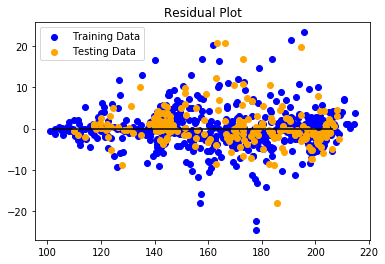

In [106]:
plt.scatter(model.predict(X_train), model.predict(X_train) - Y_train, c="blue", label="Training Data")
plt.scatter(model.predict(X_test), model.predict(X_test) - Y_test, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=Y.min(), xmax=Y.max())
plt.title("Residual Plot")

In [107]:
from sklearn.metrics import mean_squared_error, r2_score

# Use our model to make predictions
predicted = model.predict(X_test)

# Score the predictions with mse and r2
mse = mean_squared_error(Y_test, predicted)
r2 = r2_score(Y_test, predicted)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2 ): {r2}")   

Mean Squared Error (MSE): 21.663532666105816
R-squared (R2 ): 0.9706136049987849


In [108]:
# Save the model. I'm Pickle Rick!
import pickle 
file = "../app/multi_regressor_model.pkl"
with open(file, 'wb')as f:
    pickle.dump(model, f)

In [109]:
# How to load the model later.
model_pkl = open("multi_regressor_model.pkl", 'rb')
loaded_model = pickle.load(model_pkl)